In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import csv
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

/home/ashmat/.miniconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 950M (0000:01:00.0)


In [4]:
def accuracy(y, p=True):
    return len(y[p == y]) / len(y)

In [5]:
X,y,fname = pickle.load(open('data/train_ndarray.pkl','rb'))

In [6]:
X_test1, id_test1 = pickle.load(open('data/test_ndarray.pkl','rb'))

In [7]:
X_train, y_train = X[:20000], y[:20000]
X_val, y_val = X[20000:22500], y[20000:22500]
X_test, y_test = X[22500:], y[22500:]

In [8]:
accuracy(y_train), accuracy(y_val), accuracy(y_test)

(0.4984, 0.4864, 0.5264)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [7]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Logistic regression

In [8]:
classifier = LogisticRegression()

In [9]:
classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
print('Training set accuracy: %0.3f%%' %(accuracy(classifier.predict(X_train), y_train)*100))
print('Validation set accuracy: %0.3f%%' %(accuracy(classifier.predict(X_val), y_val)*100))
print('Test set accuracy: %0.3f%%' %(accuracy(classifier.predict(X_test), y_test)*100))

Training set accuracy: 100.000%
Validation set accuracy: 98.600%
Test set accuracy: 98.960%


In [11]:
prediction = classifier.predict(X_test1)

In [12]:
prediction

array([False,  True, False, ..., False, False,  True], dtype=bool)

In [13]:
id_test1_predicted = np.zeros_like(id_test1)
for p,i in zip(prediction, id_test1):
    id_test1_predicted[i-1] = 0 if p else 1

In [14]:
f = open('predictions/logisticregression.csv','w')
writer = csv.writer(f)
writer.writerow(('id','label'))
for i, p in enumerate(id_test1_predicted):
    writer.writerow((i+1,p))

# Random forest

In [15]:
classifier = RandomForestClassifier(n_estimators=50)

In [16]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
print('Training set accuracy: %0.3f%%' %(accuracy(classifier.predict(X_train), y_train)*100))
print('Validation set accuracy: %0.3f%%' %(accuracy(classifier.predict(X_val), y_val)*100))
print('Test set accuracy: %0.3f%%' %(accuracy(classifier.predict(X_test), y_test)*100))

Training set accuracy: 100.000%
Validation set accuracy: 97.680%
Test set accuracy: 97.640%


# SVM
The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.

# Neural network

In [9]:
input_X = T.matrix('X')
input_shape = [None]
input_shape.extend(X_train.shape[1:])
print(input_shape)
y_true = T.vector("target Y integer",dtype='int32')

[None, 25088]


In [10]:
from lasagne.layers import *

layer = InputLayer(shape =input_shape, input_var=input_X)
layer = DenseLayer(layer,3000, nonlinearity=lasagne.nonlinearities.rectify)
layer = DropoutLayer(layer,p=0.5)
layer = DenseLayer(layer,1000, nonlinearity=lasagne.nonlinearities.rectify)
layer = DropoutLayer(layer,p=0.5)
layer = DenseLayer(layer,1000, nonlinearity=lasagne.nonlinearities.rectify)
layer = DenseLayer(layer,2, nonlinearity=lasagne.nonlinearities.softmax)

output_layer = layer

In [11]:
learning_rate = 0.005

In [12]:
y_predicted = lasagne.layers.get_output(output_layer)
y_test_predicted = lasagne.layers.get_output(output_layer, deterministic=True)
all_weights = lasagne.layers.get_all_params(output_layer)
loss = lasagne.objectives.categorical_crossentropy(y_predicted, y_true).mean()
acc = lasagne.objectives.categorical_accuracy(y_test_predicted, y_true).mean()
updates = lasagne.updates.nesterov_momentum(loss, all_weights, learning_rate=learning_rate, momentum=0.2)
train_fun = theano.function([input_X, y_true], [loss, acc], updates=updates)
accuracy_fun = theano.function([input_X, y_true], acc)
predict_fun = theano.function([input_X], y_test_predicted)

In [13]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs), batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [14]:
loss_history = []
val_acc_history = []
train_acc_history = []

Epoch 10 of 10 took 14.028s
  training loss (in-iteration):		0.035925
  train accuracy:		99.64 %
  validation accuracy:		98.26 %


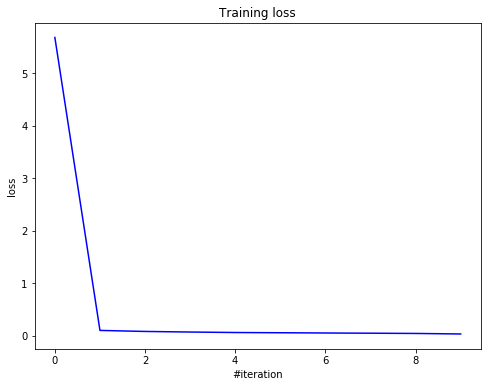

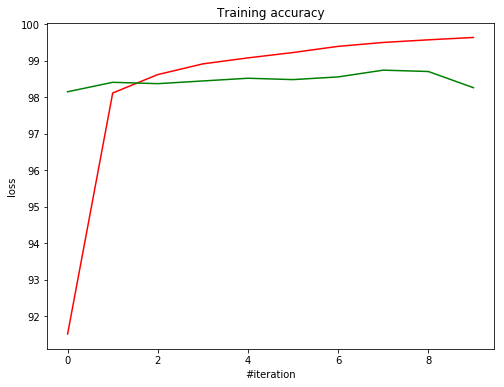

In [15]:
import time
from IPython import display

num_epochs = 10 #amount of passes through the data

batch_size = 300 #number of samples processed at each function call

for epoch in range(num_epochs):
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    loss = train_err / train_batches
    val_acc = val_acc / val_batches * 100
    train_acc = train_acc / train_batches * 100
    loss_history.append(loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    if epoch % 1 == 0:
        display.clear_output(wait=True)

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration):\t\t{:.6f}".format(loss))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc))
        plt.figure(figsize=(8, 6))
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.figure(figsize=(8, 6))
        plt.title("Training accuracy")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(train_acc_history, 'r')
        plt.plot(val_acc_history, 'g')
        
        plt.show()

In [15]:
def accuracy_batch(X, y, batch_size=300):
    acc = 0
    for inputs, targets in iterate_minibatches(X, y, batch_size):
#         predictions = predict_fun(inputs)
#         print(predictions, targets)
        acc = accuracy_fun(inputs, targets) * inputs.shape[0] + acc
    return acc / X.shape[0]

In [2]:
print('Training set accuracy: %0.3f%%' %(accuracy_batch(X_train, y_train)*100))
print('Validation set accuracy: %0.3f%%' %(accuracy_batch(X_val, y_val)*100))
print('Test set accuracy: %0.3f%%' %(accuracy_batch(X_test, y_test)*100))

NameError: name 'accuracy_batch' is not defined

In [ ]:
def predict_batch(X, batch_size=300):
    predictions = []
    for start in range(0,X.shape[0],batch_size):
        X_batch = X[start:start + batch_size]
        prediction = predict_fun(X_batch).argmax(axis=1)
        predictions.extend(prediction.tolist())
    return np.array(predictions)


In [ ]:
prediction = predict_batch(X_test1)

In [ ]:
prediction.shape

In [ ]:
id_test1_predicted = np.zeros_like(id_test1, dtype=float)
for p,i in zip(prediction, id_test1):
#     id_test1_predicted[i-1] = 0.5 + (-0.3 if p==1 else 0.3) #for kaggle scoring
    id_test1_predicted[i-1] = 0 if p==1 else 1

In [ ]:
f = open('predictions/neuralnetwork_1.csv','w')
writer = csv.writer(f)
writer.writerow(('id','label'))
for i, p in enumerate(id_test1_predicted):
    writer.writerow((i+1,p))

# Score

$$
\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right],
$$
* n is the number of images in the test set
* ŷ is the predicted probability of the image being a dog
* y is 1 if the image is a dog, 0 if cat
* log() is the natural (base e) logarithm

$$
P[y=1] = 0.8
$$

$$
P[y=0] = 0.2
$$

$$
-\textrm{LogLoss} = acc \log(0.8) + (1-acc) \log(0.2)
$$

$$
acc = - \frac{\textrm{LogLoss} + \log(0.2)}{\log(0.8) - \log(0.2)}
$$

In [ ]:
import math

### with neural network

In [ ]:
L = 0.24621 #logloss
acc = -(L + math.log(0.2)) / (math.log(0.8) - math.log(0.2))
print('Kaggle score %0.3f %%' %(acc*100))

### with logistic regression

In [ ]:
L = 0.24832
acc = -(L + math.log(0.2)) / (math.log(0.8) - math.log(0.2))
print('Kaggle score %0.3f %%' %(acc*100))

# Coclusion

I couldn't submit anything here (https://www.kaggle.com/c/dogs-vs-cats) so I've done it here(https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition), which only scored by logloss. So I converted logloss to accuracy (I hope I've done it correct).

## Save NN parameters


In [21]:
f = open('data/NN_weights.pkl','wb')

In [22]:
for param in all_weights:
    pickle.dump(param.get_value(), f)
#     print(param.get_value().shape)

In [23]:
f.close()

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
print "I can do it!"